## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 2

- **100 points [7% of your final grade]**
- **Due Sunday, March 6 by 11:59pm** 
- (*no submissions accepted after March 9 by 11:59pm*)

**Goals of this homework:** There are four objectives of this homework: 

* Become familiar with Apache Spark;
* Get hands-on experience using Spark built-in functions like PageRank;
* Work out Hubs and Authorities by hand;
* Try some LSH problems.

*Submission instructions:* You should post your notebook to canvas (look for the homework 2 assignment there). Name your submission **your-uin_hw2.ipynb**, so for example, my submission would be something like **555001234_hw2.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. When you are done, download your notebook from colab and submit it to canvas.

*Collaboration declaration:* If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

*Write your collaboration/references here*

## Preliminaries: Introduction to the Dataset
We will use a dataset of tweets concerning members of the US congress. The data spans almost a year (from October 3rd, 2018 to September 25th, 2019) covering 576 of the members. Any tweet or retweet posted by the 576 members or directed to them by other Twitter users were collected.

Originally there were more than 200 million tweets collected but we have sampled 400,000 tweets for this homework.

Below is a summary of all datasets used for this homework:

| Dataset                        | Description |
| :---                                                       | :---
| Congress members               | 576 twitter ids and screen names |
| Sample tweets                  |400k sample tweets|
| ~~User hashtags~~                  | ~~all pairs of <user, hashtag>~~|
| User mentions                  | all pairs of <src_user_id, src_dest_id, frequency> |



Following are the steps that you need to execute to install spark. Remember you need to execute them everytime after your runtime is disconnected

In [1]:
!pip install pyspark
!pip install graphframes
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!curl -L -o "/usr/local/lib/python3.7/dist-packages/pyspark/jars/graphframes-0.8.1-spark3.0-s_2.12.jar" https://repos.spark-packages.org/graphframes/graphframes/0.8.1-spark3.0-s_2.12/graphframes-0.8.1-spark3.0-s_2.12.jar
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     |████████████████████████████████| 281.4 MB 37 kB/s 
     |████████████████████████████████| 198 kB 41.7 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=f48acc192cae567f83d4eaa279bf1ca96515f284af35e1756542e1bc973492d0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
     |████████████████████████████████| 154 kB 5.0 MB/s 
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 

The cell below will download the dataset from S3 to us-congress-tweets directory

In [2]:
!mkdir us-congress-tweets
!wget https://us-congress.s3.amazonaws.com/congress_members.csv -O us-congress-tweets/congress_members.csv
!wget https://us-congress.s3.amazonaws.com/tweets-sample-400k.json -O us-congress-tweets/tweets-sample-400k.json
!wget https://us-congress.s3.amazonaws.com/user_hashtags-1m.csv -O us-congress-tweets/user_hashtags-1m.csv
!wget https://us-congress.s3.amazonaws.com/user_mentions.csv -O us-congress-tweets/user_mentions.csv

--2022-03-07 05:17:34--  https://us-congress.s3.amazonaws.com/congress_members.csv
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 54.231.195.233
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|54.231.195.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13835 (14K) [text/csv]
Saving to: ‘us-congress-tweets/congress_members.csv’

us-congress-tweets/ 100%[===================>]  13.51K  --.-KB/s    in 0s      

2022-03-07 05:17:34 (51.7 MB/s) - ‘us-congress-tweets/congress_members.csv’ saved [13835/13835]

--2022-03-07 05:17:34--  https://us-congress.s3.amazonaws.com/tweets-sample-400k.json
Resolving us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)... 54.231.195.233
Connecting to us-congress.s3.amazonaws.com (us-congress.s3.amazonaws.com)|54.231.195.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 202495914 (193M) [application/json]
Saving to: ‘us-congress-tweets/tweets-

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

In [4]:
# create a Spark session
# conf = SparkConf().set("spark.ui.port", "4050")

conf=conf = SparkConf().conf = SparkConf().set("spark.ui.port", "4050").set("spark.executor.memory", "30g").set("spark.driver.memory", "8g")
# create a Spark context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()


In [5]:
# First let's read Twitter ids and screen names of the 576 US congress members

congress_members = spark.read.csv("us-congress-tweets/congress_members.csv", header=True)
congress_members.show()
print("Number of congress members tracked:", congress_members.count())

+------------------+---------------+
|            userid|    screen_name|
+------------------+---------------+
|         776664410|  RepCartwright|
|         240363117|   RepTomMarino|
|837722935095930883| RepScottTaylor|
|        1069124515|     RepLaMalfa|
|818460870573441028|  RepTomGarrett|
|         163570705|     repcleaver|
|          19739126|      GOPLeader|
|          33563161| RepJoseSerrano|
|        2861616083|USRepGaryPalmer|
|        1074518754| SenatorBaldwin|
|         305620929|  Call_Me_Dutch|
|         381152398| RepTerriSewell|
|         834069080| RepDavidRouzer|
|         249787913|  SenatorCarper|
|         188019606|        Clyburn|
|         217543151|SenatorTimScott|
|          39249305| USRepMikeDoyle|
|          33537967|   amyklobuchar|
|         249410485|  SanfordBishop|
|          23124635|    TomColeOK04|
+------------------+---------------+
only showing top 20 rows

Number of congress members tracked: 576


We can use `spark.read.json(...)` without schema to load the tweets into a dataframe but this will be slow for two reasons:
* First, it will make one pass over the data to build a schema of the content, then a second pass to read the content and parse it to the dataframe. 
* It will read all the content of the Tweet JSON objects but we only need few fields for a given task.

Thus we define our own schema something like the following:

In [6]:
from pyspark.sql.types import *
import pyspark.sql.functions as F
twitter_date_format="EEE MMM dd HH:mm:ss ZZZZZ yyyy"

user_schema = StructType([
    StructField('created_at', TimestampType(), True),
    StructField('followers_count', LongType(), True),
    StructField('id', LongType(), True),
    StructField('name', StringType(), True),
    StructField('screen_name', StringType(), True)
])

hashtag_schema = ArrayType(StructType([StructField('text', StringType(), True)]))
user_mentions_schema = ArrayType(StructType([StructField('id', LongType(), True),
                                             StructField('screen_name', StringType(), True)]))
entities_schema = StructType([
    StructField('hashtags', hashtag_schema, True),
    StructField('user_mentions', user_mentions_schema, True)
    ])

retweeted_status_schema =StructType([        
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema)
    ])

tweet_schema =StructType([
        StructField("text", StringType(), True),
        StructField("id", LongType(), True),
        StructField("in_reply_to_user_id", LongType(), True),
        StructField("in_reply_to_status_id", LongType(), True),
        StructField("created_at", TimestampType(), True),
        StructField("user", user_schema),
        StructField("entities", entities_schema),
        StructField("retweeted_status", retweeted_status_schema)
    ])

Now we are ready to read the tweets with `spark.read.json` passing our own schema as follows:

In [7]:
tweets = spark.read.option("timestampFormat", twitter_date_format)\
                   .json('us-congress-tweets/tweets-sample-400k.json', tweet_schema)\
                   .withColumn('user_id',F.col('user.id'))
tweets.printSchema()

root
 |-- text: string (nullable = true)
 |-- id: long (nullable = true)
 |-- in_reply_to_user_id: long (nullable = true)
 |-- in_reply_to_status_id: long (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- user: struct (nullable = true)
 |    |-- created_at: timestamp (nullable = true)
 |    |-- followers_count: long (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |    |-- screen_name: string (nullable = true)
 |-- entities: struct (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = true)
 |    |-- user_mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- id: long (nullable = true)
 |    |    |    |-- screen_name: string (nullable = true)
 |-- retweeted_status: struct (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- in_reply_to_user_id: long (nul

## (30 points) Part 1: Let's Fire up Spark for Real

Okay, now that we've finally got our data loaded, we are ready to get our hands dirty with Spark. As you know, Spark comes with lots of built-in functions and nice capabilities. Indeed, you will find that to answer the problems below, there are **many** possible approaches. Please refer to the Stanford Spark tutorial we posted alongside this homework. Also feel free to Google around for some Spark resources, but we list a few here to get you started:

* https://spark.apache.org/docs/latest/sql-ref-functions-builtin.html#aggregate-functions
* https://spark.apache.org/docs/latest/sql-getting-started.html#running-sql-queries-programmatically


### Exploratory Data Analysis

a) How many unique users are there? 

In [8]:
# your code here for unique users

# print (tweets.show(5))

unique_users=tweets.select('user.id').distinct()

print ("Number of unique users: {}".format(unique_users.count()))

Number of unique users: 198098


b) How many times is the user **GOPLeader** mentioned?


In [10]:
# code here


GOP_Leaders_mentions=tweets.select('id', F.explode('entities.user_mentions.screen_name')).where("col=='GOPLeader'").distinct()
print ("GOPLeader was mentioned: {} times".format(GOP_Leaders_mentions.count()))

GOPLeader was mentioned: 4728 times


c) Now find the top-5 most mentioned members of Congress.

In [11]:
# code here

# tweets.head(1)


screen_names_ids=tweets.select('id',F.explode('entities.user_mentions.id').alias('newId')).distinct()



top5screen_ids=screen_names_ids.join(congress_members, congress_members.userid==screen_names_ids.newId,how='inner').groupBy('newId').count()\
                        .sort(F.desc('count')).limit(5)

top5screen_names=top5screen_ids.join(congress_members,congress_members.userid==top5screen_ids.newId,how='inner').sort(F.desc('count')).select("screen_name","count")\
                                .withColumnRenamed('count','No. of Mentions')

print ("\nTop 5 most mentioned members of Congress are as follows: \n")

top5screen_names.show()


Top 5 most mentioned members of Congress are as follows: 

+---------------+---------------+
|    screen_name|No. of Mentions|
+---------------+---------------+
|    NancyPelosi|          16006|
|   senatemajldr|          14903|
|LindseyGrahamSC|          14251|
|     SenSchumer|          13636|
|  RepAdamSchiff|          13183|
+---------------+---------------+



d) For each month in the dataset, report the top-5 most mentioned users (across all users in the dataset, not just the members of Congress). 

In [46]:
# code here
months=['January','February','March','April','May','June','July','August','September','October','November','December']
years=[2018,2019]

for yr in years:
  for idx,month in enumerate(months):
    tweets_filtered=tweets.where(F.year(tweets.created_at) == yr).where(F.month(tweets.created_at) == idx+1)
    if tweets_filtered.count()!=0:
      screen_names=tweets_filtered.select(F.explode('entities.user_mentions')).select(F.col("col.*")).dropDuplicates(['id'])
      screen_ids=tweets_filtered.select('id',F.explode('entities.user_mentions.id').alias('newId'))

      distinct_screen_ids=screen_ids.distinct()



      top5screen_ids=distinct_screen_ids.groupBy('newId').count().sort(F.desc('count')).limit(5)

      top5screen_names=top5screen_ids.join(screen_names, screen_names.id==top5screen_ids.newId,how='inner').sort(F.desc('count')).select("id","screen_name","count")\
                                      .withColumnRenamed('count','No. of Mentions')


      print("\nTop 5 most mentioned users for {} month and year {}:\n".format(month, yr))
      top5screen_names.show()




Top 5 most mentioned users for October month and year 2018:

+---------+---------------+---------------+
|       id|    screen_name|No. of Mentions|
+---------+---------------+---------------+
| 19726613| SenatorCollins|           2970|
| 16056306|      JeffFlake|           1624|
|432895323|LindseyGrahamSC|           1544|
| 25073877|realDonaldTrump|           1492|
| 18061669|  lisamurkowski|           1424|
+---------+---------------+---------------+


Top 5 most mentioned users for November month and year 2018:

+---------+---------------+---------------+
|       id|    screen_name|No. of Mentions|
+---------+---------------+---------------+
| 25073877|realDonaldTrump|           1788|
| 15745368|     marcorubio|           1247|
|942156122|    RepSwalwell|           1068|
| 15764644|    NancyPelosi|           1030|
|432895323|LindseyGrahamSC|            989|
+---------+---------------+---------------+


Top 5 most mentioned users for December month and year 2018:

+----------+------

e) Do you notice anything interesting in your monthly analysis?

## ANSWER:

Following are my observations:

1. The data spans from October 2018 to September 2019. Initially I was showing the top 5 members from January to December but then I re-arranged the output of my code in a chronological order to look more appropriate.

2. The twitter screen name "realDonaldTrump" belonging to Donald Trump is present in the top 5 lists of all the months indicating he was one of the most mentioned users throughout that period.


3. Donald Trump was the President during that time and he was also an active participant in Twitter which can be the reasons why his account is one of the most mentioned Twitter accounts during that period.

4. Also, another very interesting fact is that Speaker Nancy Pelosi has 2 different screen names: "NancyPelosi" and "SpeakerPelosi". So that's why I had to count the number of mentions based on user ids and not user screen names to get the proper counts.

5. Since Nancy Pelosi was the speaker during that time period she has also been predominantly one of the most mentioned twitter users during that period with her name arriving in almost all the top 5 lists. She is also the highest mentioned Congress member all throughout the year. 

6. We can also see that the top 5 names in these months contains names of people from Congress also. Since the dataset provided is a political dataset so we can predominantly see the names of different politicians in these top 5 lists.



## (25 points) Part 2: PageRank
Now let's find out who are the most important users in the dataset by running PageRank over the mentions network. For this problem, we'll define a user-mentions network using relations in `us-congress-tweets/user_mentions.csv`. That is, each user is a node in the graph. If user A mentions user B, then there should be an edge from A to B.

Hint:
* Take a look at GraphFrames: https://graphframes.github.io/graphframes/docs/_site/user-guide.html


In [47]:
# your network construction code here

from graphframes import GraphFrame

Edge = spark.read.csv("us-congress-tweets/user_mentions.csv", header=True)

Vertex =Edge.select('src').union(Edge.select('dst')).distinct()

Vertex=Vertex.withColumnRenamed('src','id')

Graph=GraphFrame(Vertex,Edge)


How many vertices are there in your network? And how many edges?

In [48]:
# your code

print("\nNumber of vertices in the Network : {}\n".format(Vertex.count()))
print("\nNumber of edges in the Network : {}\n".format(Edge.count()))


Number of vertices in the Network : 1133350


Number of edges in the Network : 2064872



Now you can run PageRank on the constructed network. Feel free to use the implementation provided as part of GraphFrames. Use a reset (or teleportation probability) of 0.15. 

In [50]:
# your PageRank code here (should be pretty short since you're just calling a function)

ranks=Graph.pageRank(resetProbability=0.15, maxIter=50)

OK, let's see what we found. List the top-10 users based on the PageRank values calculated above.

In [51]:
# Top 10 accounts 

print("\nTop 10 accounts based on the PageRank Method\n")
top10=ranks.vertices.sort(F.desc('pagerank')).limit(10)
top10.show()


Top 10 accounts based on the PageRank Method

+------------------+-----------------+
|                id|         pagerank|
+------------------+-----------------+
|          25073877|6811.718772478222|
|         240393970|6209.618424497606|
|          15764644|  5192.2310442816|
|        1249982359| 5155.75735000095|
|822215679726100480|5096.853886150923|
|          29442313|4690.872058865101|
|          15745368|4422.107161298183|
|         242555999|4333.291501736539|
|          17494010|4293.070958742832|
|         242426145|4275.494968860531|
+------------------+-----------------+



In [57]:
screen_names=tweets.select(F.explode('entities.user_mentions')).select(F.col("col.*")).dropDuplicates(['id']).withColumnRenamed('id','newID')
top10screen_names=top10.join(screen_names, screen_names.newID==top10.id,how='inner').sort(F.desc('pagerank')).drop('newID')

top10screen_names.show()

+------------------+-----------------+---------------+
|                id|         pagerank|    screen_name|
+------------------+-----------------+---------------+
|          25073877|6811.718772478222|realDonaldTrump|
|         240393970|6209.618424497606|  RepJeffDuncan|
|          15764644|  5192.2310442816|    NancyPelosi|
|        1249982359| 5155.75735000095|   senatemajldr|
|822215679726100480|5096.853886150923|          POTUS|
|          29442313|4690.872058865101|     SenSanders|
|          15745368|4422.107161298183|     marcorubio|
|         242555999|4333.291501736539|  SenWhitehouse|
|          17494010|4293.070958742832|     SenSchumer|
|         242426145|4275.494968860531|    RepMcGovern|
+------------------+-----------------+---------------+



The account id and screen_names of top 10 users based on PageRank are displayed as shown above.

What do you observe? are the top 10 users congress members? are there outsiders?

Hint: You can use https://twitter.com/intent/user?user_id=? to find out more info about the users

### ANSWER:

These twitter ids maps to the following accounts:

1. https://twitter.com/intent/user?user_id=25073877 => Belonged to Donald Trump but does not exist anymore

2. https://twitter.com/intent/user?user_id=240393970 => Rep. Jeff Duncan

3. https://twitter.com/intent/user?user_id=15764644 => Nancy Pelosi

4. https://twitter.com/intent/user?user_id=1249982359 => Leader McConnell

5. https://twitter.com/intent/user?user_id=822215679726100480 => President Trump 45 Archived

6. https://twitter.com/intent/user?user_id=29442313 => Bernie Sanders

7. https://twitter.com/intent/user?user_id=15745368 => Marco Rubio

8. https://twitter.com/intent/user?user_id=242555999 => Sheldon Whitehouse

9. https://twitter.com/intent/user?user_id=17494010 => Chuck Schumer

10. https://twitter.com/intent/user?user_id=242426145 => Rep. Jim McGovern


Following are my observations from the above data:

1. The top most account is that of Donald Trump which doesn't exist anymore

2. Other than the account of Donald Trump and the account of 'President Trump 45 Archived', the other accounts are mostly of the Congress Members

3. After a certain value of maxIter in the function Graph.pageRank the top 10 users output from the PageRank algorithm stay the same.

4. These results also indicate that Donald Trump was the most mentioned user around that time period.

5. Nancy Pelosi also appears in the top 10 list which is obvious as she was the House speaker at that time and was very influential and active on Twitter

6. POTUS45 or the account 'President Trump 45 Archived' also appears in the Top 10 list. This was the official account of the 45th President of the United States and the results indicate that people have also interacted a lot with
this account.

7. From these results we can also see that other prominent political figures such as Bernie Sanders, Leader McConnell etc. were also very active on Twitter.


## (5 points) Bonus Question (Optional)
Until now you have explored different aspects of Spark to investigate tweets by the US Congress. For this (optional) bonus problem, please conduct your own investigation of the data. You can use any combinations of the data files to carry out your investigation. You may use any libraries in Spark that you like, but you must use Spark. Tell us what question motivates you, what you did, what you discovered, and why it is interesting. This is completely open-ended, but we are looking for compelling questions and insights. Good luck!



Feel free to add any number of code/text cells here for your answer!


### ANSWER:

For this question I would like to investigate what the users mostly talked about during this period. For that we can use the hashtags from the given dataset and figure out the hashtags that has the top counts. This will give us an idea of what were the most discussed topics during that time period.



In [58]:
tweets.select('id',F.explode('entities.hashtags')).select('id',F.col("col.*")).distinct()\
        .groupby(F.lower('Text')).count().sort(F.col('count').desc())\
          .withColumnRenamed('lower(Text)','Hashtags').select('Hashtags','count').show(25)

+-------------+-----+
|     Hashtags|count|
+-------------+-----+
|    venezuela| 1275|
|  moscowmitch|  953|
|trumpshutdown|  753|
|         maga|  575|
|muellerreport|  400|
|        trump|  398|
| buildthewall|  365|
|  nancypelosi|  362|
| maduroregime|  354|
|    kavanaugh|  307|
| greennewdeal|  303|
|     breaking|  289|
| forthepeople|  229|
|       maduro|  228|
|    democrats|  223|
|    transport|  218|
|      mueller|  184|
|          gop|  183|
| dowhatwesaid|  179|
|         sotu|  178|
|          hr1|  169|
|  wethepeople|  159|
|      florida|  155|
|        qanon|  152|
| americafirst|  151|
+-------------+-----+
only showing top 25 rows



Some of the topics most discussed by the particular users of Twitter in the given dataset are shown above:

1. The most used hashtag is that of 'venezuela'. During the 2018-2019 timeframe people were discussing about the ongoing crisis in Venezuela due to rise in inflation, crime, economic decline, shortage of power, food, medicine and other essential supplies in the country. So that's why the hashtag 'venezuela' had appeared on the top of this list.

2. Second most trending hashtag is that of 'moscowmitch' because there were certain political allegations against Leader McConnell and people were discussing a lot about it during that time period.

3. The United States federal government had shutdown from December 22, 2018, till January 25, 2019 and this was the longest US government shutdown in history. Hence the hashtag 'trumpshutdown' was trending during that period.

4. Some of the other hashtags on top are that of 'trump' and 'buildthewall' which refers to Donald Trump's attempts to build a wall along the Mexico–U.S. border and donation campaigns for such efforts.


By doing this kind of analysis on the hashtags of Twitter Data, Data Analysts can figure out what are the most discussed topics amongst the general public. This data can be used in various ways such as, prediction of voting results, prediction of the percentage of support for a certain party, general thoughts of people about different parties. This data can also be used by politicians to figure out strategies to please the general public and in gaining more confidence amongst them.



________________________________________________________________________________

## (20 points) Hubs and Authorities by Hand

Consider the following graph (in adjacency list format):

* A: B, D (that is, A links to B and to D)
* B: D, E
* C: D, E
* D: F, G
* E: C, D, G, H
* F: 
* G: 
* H: C, G

Find the hub and authority score for each node. Please normalize your final scores so they sum to 1.

## ANSWER:

Let us denote hub score for a particular node A at iteration i as h<sub>i</sub>(A) and authority score for a particular node A at iteration i as a<sub>i</sub>(A).

From the given graph we can say that:


| Hubs at ith iteration  | Authorities at ith iteration |
| ----------- | ----------- |
| h<sub>i</sub>(A) = a<sub>i-1</sub>(B) + a<sub>i-1</sub>(D)      | a<sub>i</sub>(A) = 0        |
| h<sub>i</sub>(B) =  a<sub>i-1</sub>(D) + a<sub>i-1</sub>(E)     | a<sub>i</sub>(B) = h<sub>i-1</sub>(A)     |
|h<sub>i</sub>(C) =  a<sub>i-1</sub>(D) + a<sub>i-1</sub>(E) |a<sub>i</sub>(C) = h<sub>i-1</sub>(E)+ h<sub>i-1</sub>(H)|
|h<sub>i</sub>(D) =  a<sub>i-1</sub>(F) + a<sub>i-1</sub>(G)  |a<sub>i</sub>(D) = h<sub>i-1</sub>(B)+ h<sub>i-1</sub>(C)+h<sub>i-1</sub>(E)+ h<sub>i-1</sub>(A)|
|h<sub>i</sub>(E) = a<sub>i-1</sub>(C) + a<sub>i-1</sub>(D) + a<sub>i-1</sub>(G)  + a<sub>i-1</sub>(H)|a<sub>i</sub>(E) = h<sub>i-1</sub>(B)+ h<sub>i-1</sub>(C)|
|h<sub>i</sub>(F) = 0|a<sub>i</sub>(F) = h<sub>i-1</sub>(D)|
|h<sub>i</sub>(G) = 0|a<sub>i</sub>(G) = h<sub>i-1</sub>(D)+ h<sub>i-1</sub>(H)+h<sub>i-1</sub>(E)|
|h<sub>i</sub>(H) = a<sub>i-1</sub>(C) + a<sub>i-1</sub>(G) |a<sub>i</sub>(H) = h<sub>i-1</sub>(E)|



We initialize all values of hubs and authorities to 1 at the 0th iteration:

At 0th iteration:

| Hubs at 0th iteration  | Authorities at 0th iteration |
| ----------- | ----------- |
| h<sub>0</sub>(A) =  1   | a<sub>0</sub>(A) =    1    |
| h<sub>0</sub>(B) =  1    | a<sub>0</sub>(B) =    1    |
|h<sub>0</sub>(C) =  1 |a<sub>0</sub>(C) =    1 |
|h<sub>0</sub>(D) = 1  |a<sub>0</sub>(D) =    1|
|h<sub>0</sub>(E) =  1|a<sub>0</sub>(E) =   1|
|h<sub>0</sub>(F) = 1|a<sub>0</sub>(F) =   1|
|h<sub>0</sub>(G) = 1|a<sub></sub>(G) =   1|
|h<sub>0</sub>(H) = 1 |a<sub>0</sub>(H) =   1|

Then using the graph relations we get:

At 1st iteration:


| Hubs at 1st iteration  | Authorities at 1st iteration |
| ----------- | ----------- |
| h<sub>1</sub>(A) = a<sub>0</sub>(B) + a<sub>0</sub>(D)    = 2   | a<sub>1</sub>(A) = 0        |
| h<sub>1</sub>(B) =  a<sub>0</sub>(D) + a<sub>0</sub>(E)    = 2 | a<sub>1</sub>(B) = h<sub>0</sub>(A) =1    |
|h<sub>1</sub>(C) =  a<sub>0</sub>(D) + a<sub>0</sub>(E) = 2|a<sub>1</sub>(C) = h<sub>0</sub>(E)+ h<sub>0</sub>(H)=2|
|h<sub>1</sub>(D) =  a<sub>0</sub>(F) + a<sub>0</sub>(G) = 2 |a<sub>1</sub>(D) = h<sub>0</sub>(B)+ h<sub>0</sub>(C)+h<sub>0</sub>(E)+ h<sub>0</sub>(A) = 4|
|h<sub>1</sub>(E) = a<sub>0</sub>(C) + a<sub>0</sub>(D) + a<sub>0</sub>(G)  + a<sub>0</sub>(H) = 4|a<sub>1</sub>(E) = h<sub>0</sub>(B)+ h<sub>0</sub>(C) = 2|
|h<sub>1</sub>(F) = 0|a<sub>1</sub>(F) = h<sub>0</sub>(D) = 1|
|h<sub>1</sub>(G) = 0|a<sub>1</sub>(G) = h<sub>0</sub>(D)+ h<sub>0</sub>(H)+h<sub>0</sub>(E) = 3|
|h<sub>1</sub>(H) = a<sub>0</sub>(C) + a<sub>0</sub>(G) = 2|a<sub>1</sub>(H) = h<sub>0</sub>(E) = 1|

At 2nd Iteration:

| Hubs at 2nd iteration  | Authorities at 2nd iteration |
| ----------- | ----------- |
| h<sub>2</sub>(A) = a<sub>1</sub>(B) + a<sub>1</sub>(D)  = 5    | a<sub>2</sub>(A) = 0        |
| h<sub>2</sub>(B) =  a<sub>1</sub>(D) + a<sub>1</sub>(E) = 6    | a<sub>2</sub>(B) = h<sub>1</sub>(A) = 2    |
|h<sub>2</sub>(C) =  a<sub>1</sub>(D) + a<sub>1</sub>(E) = 6 |a<sub>2</sub>(C) = h<sub>1</sub>(E)+ h<sub>1</sub>(H) = 6|
|h<sub>2</sub>(D) =  a<sub>1</sub>(F) + a<sub>1</sub>(G) = 4 |a<sub>2</sub>(D) = h<sub>1</sub>(B)+ h<sub>1</sub>(C)+h<sub>1</sub>(E)+ h<sub>1</sub>(A) = 10|
|h<sub>2</sub>(E) = a<sub>1</sub>(C) + a<sub>1</sub>(D) + a<sub>1</sub>(G)  + a<sub>1</sub>(H) = 10|a<sub>2</sub>(E) = h<sub>1</sub>(B)+ h<sub>1</sub>(C) = 4|
|h<sub>2</sub>(F) = 0|a<sub>2</sub>(F) = h<sub>1</sub>(D) = 2|
|h<sub>2</sub>(G) = 0|a<sub>2</sub>(G) = h<sub>1</sub>(D)+ h<sub>1</sub>(H)+h<sub>1</sub>(E) = 8|
|h<sub>2</sub>(H) = a<sub>1</sub>(C) + a<sub>1</sub>(G) = 5 |a<sub>2</sub>(H) = h<sub>1</sub>(E) = 4|


At 3rd Iteration:

| Hubs at 3rd iteration  | Authorities at 3rd iteration |
| ----------- | ----------- |
| h<sub>3</sub>(A) = a<sub>2</sub>(B) + a<sub>2</sub>(D)  = 12    | a<sub>3</sub>(A) = 0        |
| h<sub>3</sub>(B) =  a<sub>2</sub>(D) + a<sub>2</sub>(E) = 14    | a<sub>3</sub>(B) = h<sub>2</sub>(A) = 5    |
|h<sub>3</sub>(C) =  a<sub>2</sub>(D) + a<sub>2</sub>(E) = 14 |a<sub>3</sub>(C) = h<sub>2</sub>(E)+ h<sub>2</sub>(H) = 15|
|h<sub>3</sub>(D) =  a<sub>2</sub>(F) + a<sub>2</sub>(G) = 10 |a<sub>3</sub>(D) = h<sub>2</sub>(B)+ h<sub>2</sub>(C)+h<sub>2</sub>(E)+ h<sub>2</sub>(A) = 27|
|h<sub>3</sub>(E) = a<sub>2</sub>(C) + a<sub>2</sub>(D) + a<sub>2</sub>(G)  + a<sub>2</sub>(H) = 28|a<sub>3</sub>(E) = h<sub>2</sub>(B)+ h<sub>2</sub>(C) = 12|
|h<sub>3</sub>(F) = 0|a<sub>3</sub>(F) = h<sub>2</sub>(D) = 4|
|h<sub>3</sub>(G) = 0|a<sub>3</sub>(G) = h<sub>2</sub>(D)+ h<sub>2</sub>(H)+h<sub>2</sub>(E) = 19|
|h<sub>3</sub>(H) = a<sub>2</sub>(C) + a<sub>2</sub>(G) = 14 |a<sub>3</sub>(H) = h<sub>2</sub>(E) = 10|


At 4th Iteration:



| Hubs at 4th iteration  | Authorities at 4th iteration |
| ----------- | ----------- |
| h<sub>4</sub>(A) = a<sub>3</sub>(B) + a<sub>3</sub>(D)  = 32    | a<sub>4</sub>(A) = 0        |
| h<sub>4</sub>(B) =  a<sub>3</sub>(D) + a<sub>3</sub>(E) = 39    | a<sub>4</sub>(B) = h<sub>3</sub>(A) = 12    |
|h<sub>4</sub>(C) =  a<sub>3</sub>(D) + a<sub>3</sub>(E) = 39 |a<sub>4</sub>(C) = h<sub>3</sub>(E)+ h<sub>3</sub>(H) = 42|
|h<sub>4</sub>(D) =  a<sub>3</sub>(F) + a<sub>3</sub>(G) = 23 |a<sub>4</sub>(D) = h<sub>3</sub>(B)+ h<sub>3</sub>(C)+h<sub>3</sub>(E)+ h<sub>3</sub>(A) = 68|
|h<sub>4</sub>(E) = a<sub>3</sub>(C) + a<sub>3</sub>(D) + a<sub>3</sub>(G)  + a<sub>3</sub>(H) = 71|a<sub>4</sub>(E) = h<sub>3</sub>(B)+ h<sub>3</sub>(C) = 28|
|h<sub>4</sub>(F) = 0|a<sub>4</sub>(F) = h<sub>3</sub>(D) = 10|
|h<sub>4</sub>(G) = 0|a<sub>4</sub>(G) = h<sub>3</sub>(D)+ h<sub>3</sub>(H)+h<sub>3</sub>(E) = 52|
|h<sub>4</sub>(H) = a<sub>3</sub>(C) + a<sub>3</sub>(G) = 34 |a<sub>4</sub>(H) = h<sub>3</sub>(E) = 28|

Taking Normalized values we get:

| Hubs at 4th iteration  | Authorities at 4th iteration |
| ----------- | ----------- |
| h<sub>4</sub>(A) =  32/238 = 0.1344   | a<sub>4</sub>(A) =    0/240 = 0   |
| h<sub>4</sub>(B) =  39/238 = 0.1638   | a<sub>4</sub>(B) =    12/240  = 0.05  |
|h<sub>4</sub>(C) =  39/238 = 0.1638 |a<sub>4</sub>(C) =   42/240 = 0.175 |
|h<sub>4</sub>(D) = 23/238 = 0.0966 |a<sub>4</sub>(D) =   68/240 = 0.2833 |
|h<sub>4</sub>(E) =  71/238 = 0.2983|a<sub>4</sub>(E) =   28/240 = 0.1166  |
|h<sub>4</sub>(F) = 0/238 = 0|a<sub>4</sub>(F) =   10/240 = 0.0416 |
|h<sub>4</sub>(G) = 0/238 = 0|a<sub></sub>(G) =   52/240 = 0.2166 |
|h<sub>4</sub>(H) = 34/238 = 0.1428 |a<sub>4</sub>(H) =   28/240 = 0.1166 |


## (25 points) LSH Problems from the Book

From MMDS [Chapter 3](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf), do the following problems:

* Exercise 3.1.2 (Page 78)
* Exercise 3.2.2 (Page 81)
* Exercise 3.3.3 (Page 90)
* Exercise 3.4.1 (Page 96)
* Exercise 3.4.2 (Page 96)

Please add cells below with your answers (explanation and detail of calculation are required). 




### Exercise 3.1.2 (Page 78)

### ANSWER:

Given:

A = {1, 1, 1, 2}, B = {1, 1, 2, 2, 3}, C = {1, 2, 3, 4} 

Now:

(A $\cup$ B) = {1,1,1,2,1,1,2,2,3} 

(A $\cap$ B) = {1,1,2} 

(B $\cup$  C) =  {1,1,2,2,3,1,2,3,4}

(A $\cap$  B) =  {1,2,3}

(A $\cup$  C) = {1,1,1,2,1,2,3,4} 

(A $\cap$  C) = {1,2} 

Let Jaccard similarities of A and B be denoted by J(A,B)

Then the Jaccard similarities are as follows:

J(A,B) = |A $\cap$  B| / |A$\cup$ B|

$~~~~~~~~~$ =  3/9 = 1/3 

J(B,C) = |B $\cap$  C| / ||A$\cup$  B|

$~~~~~~~~~$ =  3/9 = 1/3 

J(A,C) = |A $\cap$ C| / |A $\cup$  C| 

$~~~~~~~~~$ =  2/8 = 1/4 

---------------------------------------------------------------------------






### Exercise 3.2.2 (Page 81)

### ANSWER

Given the following sentence:

"The most effective way to represent documents as sets, for the purpose of identifying lexically similar documents is to construct from the document the set of short strings that appear within it."

The stop words are defined as any word with word length less than 3.

Then the stop words in this sentence are: 

The, way, to, as, for, the, of, is, to, the, the, set, of, it

Shingles are the stop words combined with the successive 2 words in the sentence. Then the shingles in the sentence are:

1. The most effective
2. way to represent
3. to represent documents 
4. as sets for 
5. for the purpose 
6. the purpose of 
7. of identifying lexically 
8. is to construct 
9. to construct from 
10. the document the 
11. the set of 
12. set of short 
13. of short strings

A total of 13 shingles are present

\\

______________________________________________________________________________

### Exercise 3.3.3 (Page 90)

### ANSWER (a)

Given:

$h_1(x)=(2x+1)mod$ 6

$h_2(x)=(3x+2)mod$ 6

$h_3(x)=(5x+2)mod$ 6

Then we have our matrix as:

 Element | $s_1$ |$s_2$ |$s_3$ | $s_4$ | $h_1$ | $h_2$ | $h_3$ |
 --- |--- | --- | --- | ---| --- | --- | --- |
 0 | 0 | 1 | 0 | 1 |  1 | 2 | 2
 1 | 0 | 1 | 0 | 0 |  3 | 5 | 1
 2 | 1 | 0 | 0 | 1 |   5 | 2 | 0
 3 | 0 | 0 | 1 | 0 |  1 | 5 | 5
 4 | 0 | 0 | 1 | 1 | 3 | 2 | 4
 5 | 1 | 0 | 0 | 0 | 5 | 5 | 3



And following is our Minhash signature matrix:


. |$s_1$ |$s_2$ |$s_3$ | $s_4$ |
--- |--- | --- | --- | ---|
 $h_1$ | 5 | 1 | 1 | 1
$h_2$ | 2 | 2 | 2 | 2
$h_3$ | 0 | 1 | 4 | 0





### ANSWER (b)

From the values of $h_3(x)$ we can see that it is a true permutation function amongst the 3 given functions as its values are unique.






### ANSWER (c)

Let the estimated Jaccard similarity of (A, B) be $J_a(A,B)$ and the true Jaccard similarity of (A, B) be $J_b(A,B)$


Estimated jaccard similarities are as follows:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_a(s_1,s_2)$ = 1/3 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$  $J_a(s_2,s_3)$ = 2/3 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$  $J_a(s_3,s_4)$ = 2/3 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_a(s_1,s_4)$ = 2/3 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_a(s_2,s_4)$ = 2/3 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_a(s_1,s_3)$ = 1/3 


True jaccard similarities are as follows:

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_1,s_2)$ = 0 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_2,s_3)$ = 0 

 $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_3,s_4)$ = 1/4 

 $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_1,s_4)$ = 1/4 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_2,s_4)$ = 1/4 

$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~$ $J_b(s_1,s_3)$ = 0 


Thus we can see that the Estimated jaccard similarities and True jaccard similarities are not close to each other. The possible reason for this could be the choice of our hashing functions. Since 2 of them are not true permutations they are not as effective. If we would have chosen all 3 of the hashing functions to be true permutations then we might have obtained better results.

\\

 ____________________________________________________________________________

### Exercise 3.4.1 (Page 96)

### ANSWER:

Given: 

The S-curve:   $1 - (1-s^r)^b$

Values of s:  0.1, 0.2, . . . , 0.9, for
the following values of r and b:

• r = 3 and b = 10.

• r = 6 and b = 20.

• r = 5 and b = 50.

Following are the plots of the S-curves:


Following are the values of probabilities and the plots of the S-curves:



Calculated values for r = 3 and b = 10

  s  Probability
0.1     0.009955
0.2     0.077181
0.3     0.239449
0.4     0.483871
0.5     0.736924
0.6     0.912267
0.7     0.985015
0.8     0.999234
0.9     0.999998




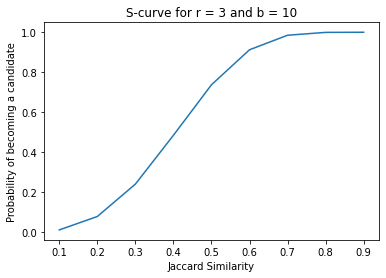




Calculated values for r = 6 and b = 20

  s  Probability
0.1     0.000020
0.2     0.001279
0.3     0.014479
0.4     0.078809
0.5     0.270187
0.6     0.615415
0.7     0.918186
0.8     0.997712
0.9     1.000000




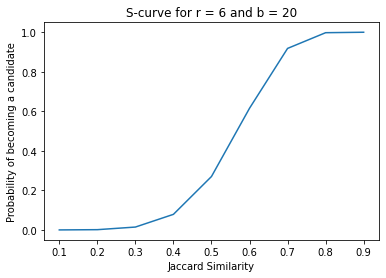




Calculated values for r = 5 and b = 50

  s  Probability
0.1     0.000500
0.2     0.015875
0.3     0.114540
0.4     0.402284
0.5     0.795551
0.6     0.982534
0.7     0.999899
0.8     1.000000
0.9     1.000000




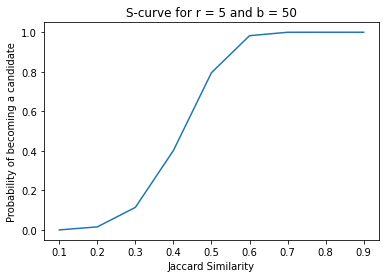

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
s_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

r_values = [3, 6, 5]

b_values = [10, 20, 50]

print ("Following are the values of probabilities and the plots of the S-curves:")
for r,b in zip(r_values,b_values):
  table=[]
  output=[]
  for s in s_values:
    prob_calculated=1-pow((1-pow(s,r)),b)
    output.append(prob_calculated)

    table.append([s,prob_calculated])
  print ("\n")
  print ("\nCalculated values for r = {} and b = {}\n".format(r,b))
  df = pd.DataFrame(table, columns = ['s','Probability'])

  print(df.to_string(index=False))
  print ("\n")

  
  plt.plot(s_values, output)
  plt.xlabel("Jaccard Similarity")
  plt.ylabel("Probability of becoming a candidate")
  plt.title("S-curve for r = {} and b = {}".format(r,b))
  plt.show()



### Exercise 3.4.2

### ANSWER:

Given: 

The S-curve:   $1 - (1-s^r)^b$

then at:  $1 - (1-s^r)^b = 1/2$

 $=> s=(1-(1/2)^{(1/b)})^{(1/r)}$

The estimated value:  $(1/b)^{(1/r)}$

In [29]:
r_values = [3, 6, 5]
b_values = [10, 20, 50]

for r,b in zip(r_values,b_values):
    s=pow(1 - pow(0.5,(1/b)),(1/r))
    estimated_value = (pow((1/b),(1/r)))
    print('For the values, r = {}, b = {}, we get: \nS-value at 0.5:\n {}\nEstimated value:\n {}\n'.format(r, b, s, estimated_value))

For the values, r = 3, b = 10, we get: 
S-value at 0.5:
 0.4060881340677083
Estimated value:
 0.4641588833612779

For the values, r = 6, b = 20, we get: 
S-value at 0.5:
 0.5693533868256982
Estimated value:
 0.6069622310029172

For the values, r = 5, b = 50, we get: 
S-value at 0.5:
 0.4243944803687326
Estimated value:
 0.45730505192732634



Thus we can see that the estimated value and the value calculated for s from the equation $1 - (1-s^r)^b = 1/2$ is almost the same and so we can say that the estimation formula for getting an estimated value of the threshold works well..